<a href="https://colab.research.google.com/github/AderiP/unet-tactile-paving-segmentation/blob/main/UnetTactilePavingSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 

# トレーニングを始める前に
このプログラムはデータセットをzipで圧縮して、Dropboxに置いて共有リンクからダウンロードしています。

適宜、Googleドライブにデータセット置くなどして、データセットを取り込んでください。

# ハイパーパラメータ

In [ ]:
BATCH_SIZE = 32
SEED = 100
TEST_GROUP = 0 # Number of the group used for test data (test_group=0~4)
LEARNING_RATE = 0.0001
MAX_EPOCHS = 50

ADDITIONAL_LEARNING = True
MODEL_PATH = "/content/drive/My Drive/U-Net/"

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation, LeakyReLU
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import plot_model
from keras import backend as K
import glob
import random
import cv2
from random import shuffle
import glob
import csv
import datetime
import pandas as pd
from google.colab import files

# Check operating environment

In [ ]:
!nvidia-smi
!nvcc -V
print()

!python3 --version # -> Python 3.7.15
print("TensorFlow version -> ",tf.__version__) # TensorFlow version ->  2.9.2

Wed Dec  7 05:31:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Dataset copying from Dropbox and expansion

In [ ]:
%%capture
!wget https://www.dropbox.com/s/a5wjrb866xn6b8h/img.zip
!wget https://www.dropbox.com/s/6p7rwok1nx2zvo7/mask.zip
!unzip "mask" & unzip "img"

In [ ]:
os.mkdir('img_index')
os.mkdir('mask_index')

index_img = glob.glob('img/**/*.jpg')
for img in index_img:
  shutil.copy(img,"img_index/" + os.path.basename(img))

index_mask = glob.glob('mask/**/*.png')
for mask in index_mask:
  shutil.copy(mask,"mask_index/" + os.path.basename(mask))

# Write to hyperparameters text file & Set seed

In [ ]:
time = datetime.datetime.now()
now_time = time.strftime("%Y-%m-%d %H:%M:%S")

if ADDITIONAL_LEARNING:
  RESULT_DIR = f"/content/drive/My Drive/U-Net/{now_time} t={TEST_GROUP:d}:add"
else:
  RESULT_DIR = f"/content/drive/My Drive/U-Net/{now_time} t={TEST_GROUP:d}"

if not os.path.exists(RESULT_DIR):  # ディレクトリが存在しない場合、作成する。
    os.makedirs(RESULT_DIR, exist_ok=True)

if ADDITIONAL_LEARNING:
  textfile_name = os.path.join(RESULT_DIR,  f"{now_time} t={TEST_GROUP:d}:add parameter.txt")
else:
  textfile_name = os.path.join(RESULT_DIR,  f"{now_time} t={TEST_GROUP:d} parameter.txt")

with open(textfile_name, "w") as f:
  f.write(f"BATCH_SIZE: {str(BATCH_SIZE)}\n")
  f.write(f"SEED: {str(SEED)}\n")
  f.write(f"TEST_GROUP: {str(TEST_GROUP)}\n")
  f.write(f"LEARNING_RATE: {str(LEARNING_RATE)}\n")
  f.write(f"MAX_EPOCHS: {str(MAX_EPOCHS)}\n")
  f.write(f"ADDITIONAL_LEARNING: {str(ADDITIONAL_LEARNING)}\n")

tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

# Generators

In [ ]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'mask_index/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))

        #preprocess the mask 
        # mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'img_index/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)      
    

# Set up training and test data

In [ ]:
seq_dirs = os.listdir('img')
shuffle(seq_dirs)

print("Order of sequence directory")
print(seq_dirs)
print()

# Group of 5 divided datasets
img_groups = []
img_group = []
seq_group = []

for i, seq_dir in enumerate(seq_dirs, 1):
  img_group.extend(os.listdir('img/'+seq_dir))
  seq_group.append(seq_dir)
  if i % 4 == 0:
    img_groups.append([img_group,seq_group])
    img_group = []
    seq_group = []

train_files = []
test_files = []

for i in range(5):
  if i == TEST_GROUP:
    print("test sequence: ", end="")
    print(img_groups[i][1])

    test_files = img_groups[i][0]
  else:
    print("traint sequence: ", end="")
    print(img_groups[i][1])

    train_files.extend(img_groups[i][0])

shuffle(train_files)
shuffle(test_files) 

print("\nfirst img")
print("train sequence: ", end="")
print(train_files[0])
print("test sequence: ", end="")
print(test_files[0])

train_generator = image_generator(train_files, batch_size = BATCH_SIZE)
test_generator  = image_generator(test_files, batch_size = BATCH_SIZE)

Order of sequence directory
['04', '10', '08', '12', '13', '18', '07', '20', '11', '06', '02', '19', '14', '05', '01', '03', '09', '17', '15', '16']

test sequence: ['04', '10', '08', '12']
traint sequence: ['13', '18', '07', '20']
traint sequence: ['11', '06', '02', '19']
traint sequence: ['14', '05', '01', '03']
traint sequence: ['09', '17', '15', '16']

first img
train sequence: VID_20210731_181248_2263.jpg
test sequence: VID_20210731_175958_0530.jpg


# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $y_{true}, y_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [ ]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# Loss Function

In [ ]:
def dice_loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    y_true = tf.cast(y_true, tf.float32)

    smooth = 1. # ゼロ除算回避のための定数
    y_true_flat = tf.reshape(y_true, [-1]) # 1次元に変換
    y_pred_flat = tf.reshape(y_pred, [-1]) # 同様

    tp = tf.reduce_sum(y_true_flat * y_pred_flat) # True Positive
    nominator = 2 * tp + smooth # 分子
    denominator = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + smooth # 分母
    score = nominator / denominator
    return 1. - score

# Model

In [ ]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)

  #optimaizer
  # rmsprop = RMSprop(learning_rate=LEARNING_RATE, rho=0.9, epsilon=None, decay=0.0)
  adam = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = adam, loss = dice_loss, metrics = [mean_iou])
  
  return model

In [ ]:
model = unet()

if ADDITIONAL_LEARNING:
  model.load_weights(MODEL_PATH)

# ModelCheckpoint

In [ ]:
CHECKPOINT_DIR = os.path.join(RESULT_DIR, "checkpoint")

if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)

if ADDITIONAL_LEARNING:
  checkpoint_filepath = os.path.join(CHECKPOINT_DIR, f"{now_time} t={TEST_GROUP:d}:add " + "{epoch:03d}.h5")
else:
  checkpoint_filepath = os.path.join(CHECKPOINT_DIR, f"{now_time} t={TEST_GROUP:d} " + "{epoch:03d}.h5")

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                             save_best_only=True,
                             save_weights_only=False,
                             save_freq=10)

# Callbacks

Simple functions to save the model at each epoch and show some predictions 

In [ ]:
LOG_DIR = f"/content/drive/My Drive/U-Net/logs"

if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR, exist_ok=True)

if ADDITIONAL_LEARNING:
  log_dir_path = os.path.join(LOG_DIR, f"{now_time} t={TEST_GROUP:d}:add")
else:
  log_dir_path = os.path.join(LOG_DIR, f"{now_time} t={TEST_GROUP:d}")

def build_callbacks():
        checkpointer = checkpoint
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_path)
        callbacks = [checkpointer, PlotLearning(), tensorboard_callback]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'img_index/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1
        msk[msk < 0.5] = 0
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training Executor

In [ ]:
def training():
  train_steps = len(train_files) //BATCH_SIZE
  test_steps = len(test_files) //BATCH_SIZE
  history = model.fit(train_generator, 
                      epochs = MAX_EPOCHS,
                      steps_per_epoch = train_steps,
                      validation_data = test_generator, 
                      validation_steps = test_steps, 
                      callbacks = build_callbacks())
  hist_df = pd.DataFrame(history.history)

  if ADDITIONAL_LEARNING:
    history_csv_path = os.path.join(RESULT_DIR, f"{now_time} t={TEST_GROUP:d}:add history.csv")
  else:
    history_csv_path = os.path.join(RESULT_DIR, f"{now_time} t={TEST_GROUP:d} history.csv")


  hist_df.to_csv(os.path.join(RESULT_DIR, f"{now_time} t={TEST_GROUP:d} history.csv"))

# Test Executor

In [ ]:
def testing():
  print("\ntest data mean iou")

  if ADDITIONAL_LEARNING:
    csv_path = os.path.join(RESULT_DIR, f"{now_time} t={TEST_GROUP:d}:add result.csv")
  else:
    csv_path = os.path.join(RESULT_DIR, f"{now_time} t={TEST_GROUP:d} result.csv")

  with open(csv_path, 'w') as f:
      writer = csv.writer(f)
      writer.writerow(["img_name","iou"])

      iou_sum = 0.0

      for i, test_file in enumerate(test_files,1):
        mask = Image.open(f'mask_index/{test_file[:-4]}.png')
        mask = np.array(mask.resize((256, 256)))

        #preprocess the mask 
        mask[mask != 0 ] = 1

        raw = Image.open(f'img_index/{test_file}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]

        #predict the mask 
        pred = model.predict_on_batch(np.expand_dims(raw, 0))

        yt0 = K.cast(mask, 'float32')
        yp0 = K.cast(pred[:,:,:,0] > 0.5, 'float32')
        inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
        union = tf.math.count_nonzero(tf.add(yt0, yp0))
        iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))

        writer.writerow([test_file, iou.numpy()])

        iou_sum = iou_sum + iou.numpy()

        if i % 1000 == 0:
          print("[{:d}/{:d}] {:f}".format(i, len(test_files), iou_sum/i))

# Run

Epoch 1/10
1/1 [==============================] - 1s 832ms/step


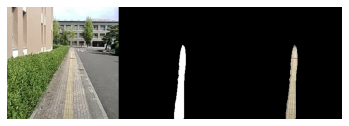

250/250 [==============================] - 224s 848ms/step - loss: 0.4023 - mean_iou: 0.4961 - val_loss: 0.1748 - val_mean_iou: 0.7042
Epoch 2/10
1/1 [==============================] - 0s 23ms/step


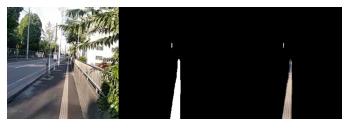

250/250 [==============================] - 214s 856ms/step - loss: 0.0798 - mean_iou: 0.8542 - val_loss: 0.0949 - val_mean_iou: 0.8283
Epoch 3/10
1/1 [==============================] - 0s 26ms/step


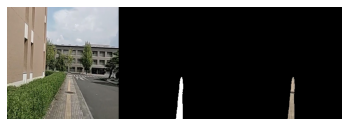

250/250 [==============================] - 205s 818ms/step - loss: 0.0522 - mean_iou: 0.9016 - val_loss: 0.0999 - val_mean_iou: 0.8205
Epoch 4/10
1/1 [==============================] - 0s 24ms/step


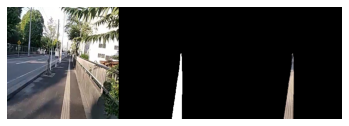

250/250 [==============================] - 211s 843ms/step - loss: 0.0435 - mean_iou: 0.9173 - val_loss: 0.0886 - val_mean_iou: 0.8383
Epoch 5/10
1/1 [==============================] - 0s 37ms/step


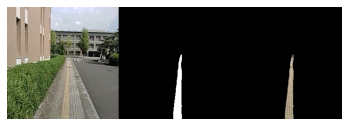

250/250 [==============================] - 219s 878ms/step - loss: 0.0376 - mean_iou: 0.9281 - val_loss: 0.0945 - val_mean_iou: 0.8285
Epoch 6/10
1/1 [==============================] - 0s 22ms/step


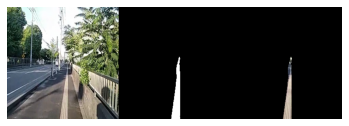

250/250 [==============================] - 214s 858ms/step - loss: 0.0338 - mean_iou: 0.9351 - val_loss: 0.0915 - val_mean_iou: 0.8334
Epoch 7/10
1/1 [==============================] - 0s 23ms/step


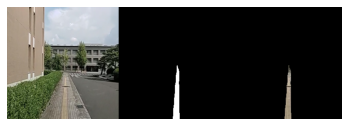

250/250 [==============================] - 221s 885ms/step - loss: 0.0301 - mean_iou: 0.9420 - val_loss: 0.0941 - val_mean_iou: 0.8291
Epoch 8/10
1/1 [==============================] - 0s 22ms/step


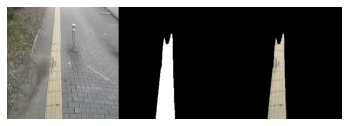

250/250 [==============================] - 196s 783ms/step - loss: 0.0323 - mean_iou: 0.9380 - val_loss: 0.0819 - val_mean_iou: 0.8497
Epoch 9/10
1/1 [==============================] - 0s 24ms/step


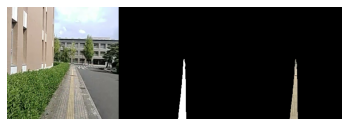

250/250 [==============================] - 208s 834ms/step - loss: 0.0287 - mean_iou: 0.9446 - val_loss: 0.0762 - val_mean_iou: 0.8595
Epoch 10/10
1/1 [==============================] - 0s 23ms/step


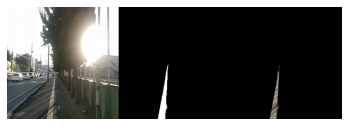

250/250 [==============================] - 214s 855ms/step - loss: 0.0261 - mean_iou: 0.9494 - val_loss: 0.0710 - val_mean_iou: 0.8679
[1000/2000] 0.881307
[2000/2000] 0.880459


In [ ]:
training()

if ADDITIONAL_LEARNING:
  model_name = os.path.join(RESULT_DIR, f"{now_time} t={TEST_GROUP:d}:add .h5")
else:
  model_name = os.path.join(RESULT_DIR, f"{now_time} t={TEST_GROUP:d}.h5")

model.save(model_name)

testing()

# TensorBoard

In [ ]:
!cp -r "/content/drive/My Drive/U-Net/logs" "."
%load_ext tensorboard
%tensorboard --logdir logs

cp: cannot stat 'LOG_DIR': No such file or directory
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 6929), started 0:01:03 ago. (Use '!kill 6929' to kill it.)

<IPython.core.display.Javascript object>